# Characterizing COVID-19 Misinformation Communities Using a Novel Twitter Dataset

In [666]:
# Import necassary Libraries 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

### <font color='green'>Load data + EDA + basic preprocessing</font>

In [1170]:
#Load dataset 

import pandas as pd
df = pd.read_csv("CMU-MisCOV19.csv")

#View the head of the dataframe
df.head(3)

,status_id,text,annontation
0,0,"PAGS PARODY! Plus, Joe talks coronavirus and h...",irrelevant
1,1,#coronavirus shows that racists have absolutel...,irrelevant
2,2,@Laura1206 @ShitChester I would expect front l...,irrelevant


In [1171]:
# Get some basic information on the dataset 
df.info()

#We can see that thankfully there are no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3642 entries, 0 to 3641
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   status_id    3642 non-null   int64 
 1   text         3642 non-null   object
 2   annontation  3642 non-null   object
dtypes: int64(1), object(2)
memory usage: 85.5+ KB


In [1172]:
#Let's look at the annontation which are essentially the categories the tweets have been categorised into.

df['annontation'].value_counts()

calling out or correction           1193
conspiracy                           510
politics                             438
sarcasm or satire                    397
false fact or prevention             253
true prevention                      160
true public health response          151
ambiguous or hard to classify        113
irrelevant                           109
news                                  92
fake cure                             92
panic buying                          65
commercial activity or promotion      29
fake treatment                        21
emergency                             16
false public health response           3
Name: annontation, dtype: int64

In [1173]:
# Drop duplicates

df.drop_duplicates(subset=['annontation', 'text'], inplace=True)
df

,status_id,text,annontation
0,0,"PAGS PARODY! Plus, Joe talks coronavirus and h...",irrelevant
1,1,#coronavirus shows that racists have absolutel...,irrelevant
2,2,@Laura1206 @ShitChester I would expect front l...,irrelevant
3,3,The coronavirus is not only affecting the way ...,irrelevant
4,4,I hope your father recovers from the virus as ...,politics
...,...,...,...
3637,3637,Da fark is wrong with these people?!\n\nhttps:...,calling out or correction
3638,3638,Doctor Finds Cure to COVID-19 (without Vaccine...,fake cure
3639,3639,I can’t believe people legitimately think that...,calling out or correction
3640,3640,"...(wrong with Trump continues), \n-Will push ...",politics


<AxesSubplot:xlabel='annontation'>

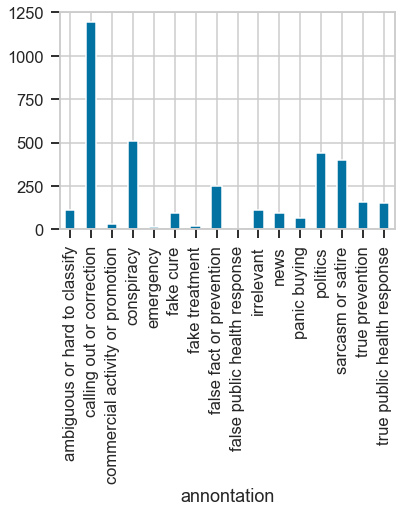

In [1174]:
#Briefly look at the different categories 

df.groupby('annontation').annontation.count().plot.bar(ylim=0)

In [1175]:
print(df['annontation'].unique())

['irrelevant' 'politics' 'true public health response' 'news'
 'calling out or correction' 'sarcasm or satire' 'fake cure' 'conspiracy'
 'true prevention' 'ambiguous or hard to classify'
 'false fact or prevention' 'panic buying'
 'commercial activity or promotion' 'fake treatment' 'emergency'
 'false public health response']


0 = misinformation, 1= not misinformation, 2= irrelevant/other/both

In [1176]:
# Map the annontation categories to whether they're misinformation or not
d={'conspiracy':0, 'fake cure':0, 'fake treatment':0, 'false fact or prevention':0, 'sarcasm or satire':0, 'false public health response':0,  'true prevention':1, 'calling out or correction':1,  'true public health response':1, 'emergency':1,  'irrelevant':2, 'politics':2, 'ambiguous or hard to classify':2, 'commercial activity or promotion':2, 'news':2, 'panic buying':2 }
df['new_cat']=df.annontation.map(d)

df

,status_id,text,annontation,new_cat
0,0,"PAGS PARODY! Plus, Joe talks coronavirus and h...",irrelevant,2
1,1,#coronavirus shows that racists have absolutel...,irrelevant,2
2,2,@Laura1206 @ShitChester I would expect front l...,irrelevant,2
3,3,The coronavirus is not only affecting the way ...,irrelevant,2
4,4,I hope your father recovers from the virus as ...,politics,2
...,...,...,...,...
3637,3637,Da fark is wrong with these people?!\n\nhttps:...,calling out or correction,1
3638,3638,Doctor Finds Cure to COVID-19 (without Vaccine...,fake cure,0
3639,3639,I can’t believe people legitimately think that...,calling out or correction,1
3640,3640,"...(wrong with Trump continues), \n-Will push ...",politics,2


In [1177]:
#Double check for any missing values as this will not less the classification model run 
nan_rows = df[df['new_cat'].isnull()]
nan_rows

,status_id,text,annontation,new_cat


In [1178]:
# Let's look at the lengths of the tweets 

df["length"] = df["text"].apply(len)
df

,status_id,text,annontation,new_cat,length
0,0,"PAGS PARODY! Plus, Joe talks coronavirus and h...",irrelevant,2,133
1,1,#coronavirus shows that racists have absolutel...,irrelevant,2,306
2,2,@Laura1206 @ShitChester I would expect front l...,irrelevant,2,241
3,3,The coronavirus is not only affecting the way ...,irrelevant,2,127
4,4,I hope your father recovers from the virus as ...,politics,2,304
...,...,...,...,...,...
3637,3637,Da fark is wrong with these people?!\n\nhttps:...,calling out or correction,1,61
3638,3638,Doctor Finds Cure to COVID-19 (without Vaccine...,fake cure,0,84
3639,3639,I can’t believe people legitimately think that...,calling out or correction,1,178
3640,3640,"...(wrong with Trump continues), \n-Will push ...",politics,2,270


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='length'>

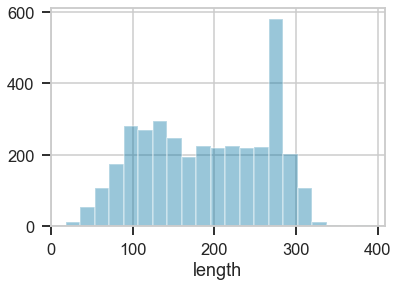

In [1179]:
# A visualisation  of the lengths of the tweets via a histogram 

sns.distplot(df["length"], kde=False)


We can see that most lengths are around 280 which makes sense as thats the limit

# <font color='Blue'>1. Text Mining and pre-processing</font>

### <font color='green'>Contraction Mapping / Expanding Contractions</font>

We'll start with contractions. These are words that are a combination of two words and are shortened by dropping letters and replacing them with an apostrophe,  for example 'shouldn't' is 'should not'. 
This step is taken in order to standardise text and to decrease dimenstionality of the document-term matrix which in turn makes the process more compuationally effecient. Tweets would more likely use contractions and we would be interested in the words as they play an importnat role in sentiment analysis. 

In [1180]:
#Import the library 

import contractions

In [1181]:
#Create a feature without the contractions 

df['no_contract'] = df['text'].apply(lambda x: [contractions.fix(word) for word in x.split()])
df

,status_id,text,annontation,new_cat,length,no_contract
0,0,"PAGS PARODY! Plus, Joe talks coronavirus and h...",irrelevant,2,133,"[PAGS, PARODY!, Plus,, Joe, talks, coronavirus..."
1,1,#coronavirus shows that racists have absolutel...,irrelevant,2,306,"[#coronavirus, shows, that, racists, have, abs..."
2,2,@Laura1206 @ShitChester I would expect front l...,irrelevant,2,241,"[@Laura1206, @ShitChester, I, would, expect, f..."
3,3,The coronavirus is not only affecting the way ...,irrelevant,2,127,"[The, coronavirus, is, not, only, affecting, t..."
4,4,I hope your father recovers from the virus as ...,politics,2,304,"[I, hope, your, father, recovers, from, the, v..."
...,...,...,...,...,...,...
3637,3637,Da fark is wrong with these people?!\n\nhttps:...,calling out or correction,1,61,"[Da, fark, is, wrong, with, these, people?!, h..."
3638,3638,Doctor Finds Cure to COVID-19 (without Vaccine...,fake cure,0,84,"[Doctor, Finds, Cure, to, COVID-19, (without, ..."
3639,3639,I can’t believe people legitimately think that...,calling out or correction,1,178,"[I, cannot, believe, people, legitimately, thi..."
3640,3640,"...(wrong with Trump continues), \n-Will push ...",politics,2,270,"[...(wrong, with, Trump, continues),, -Will, p..."


In [1182]:
#We want the newly expanded contractions to be tokensied seperately so we convert back to string form 

df["text_str"] = [' '.join(map(str, l)) for l in df['no_contract']]
df

,status_id,text,annontation,new_cat,length,no_contract,text_str
0,0,"PAGS PARODY! Plus, Joe talks coronavirus and h...",irrelevant,2,133,"[PAGS, PARODY!, Plus,, Joe, talks, coronavirus...","PAGS PARODY! Plus, Joe talks coronavirus and h..."
1,1,#coronavirus shows that racists have absolutel...,irrelevant,2,306,"[#coronavirus, shows, that, racists, have, abs...",#coronavirus shows that racists have absolutel...
2,2,@Laura1206 @ShitChester I would expect front l...,irrelevant,2,241,"[@Laura1206, @ShitChester, I, would, expect, f...",@Laura1206 @ShitChester I would expect front l...
3,3,The coronavirus is not only affecting the way ...,irrelevant,2,127,"[The, coronavirus, is, not, only, affecting, t...",The coronavirus is not only affecting the way ...
4,4,I hope your father recovers from the virus as ...,politics,2,304,"[I, hope, your, father, recovers, from, the, v...",I hope your father recovers from the virus as ...
...,...,...,...,...,...,...,...
3637,3637,Da fark is wrong with these people?!\n\nhttps:...,calling out or correction,1,61,"[Da, fark, is, wrong, with, these, people?!, h...",Da fark is wrong with these people?! https://t...
3638,3638,Doctor Finds Cure to COVID-19 (without Vaccine...,fake cure,0,84,"[Doctor, Finds, Cure, to, COVID-19, (without, ...",Doctor Finds Cure to COVID-19 (without Vaccine...
3639,3639,I can’t believe people legitimately think that...,calling out or correction,1,178,"[I, cannot, believe, people, legitimately, thi...",I cannot believe people legitimately think tha...
3640,3640,"...(wrong with Trump continues), \n-Will push ...",politics,2,270,"[...(wrong, with, Trump, continues),, -Will, p...","...(wrong with Trump continues), -Will push pr..."


### <font color='green'> Noise cleaning and tokenisation</font>

In [1183]:
#Import libarary needed for noise cleaning
import regex as re

#Make lower case and remove special characters and white spaces
df['text_str'] = df['text_str'].str.lower()
df['text_str'] = df['text_str'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))
df


,status_id,text,annontation,new_cat,length,no_contract,text_str
0,0,"PAGS PARODY! Plus, Joe talks coronavirus and h...",irrelevant,2,133,"[PAGS, PARODY!, Plus,, Joe, talks, coronavirus...",pags parody plus joe talks coronavirus and has...
1,1,#coronavirus shows that racists have absolutel...,irrelevant,2,306,"[#coronavirus, shows, that, racists, have, abs...",coronavirus shows that racists have absolutely...
2,2,@Laura1206 @ShitChester I would expect front l...,irrelevant,2,241,"[@Laura1206, @ShitChester, I, would, expect, f...",laura1206 shitchester i would expect front lin...
3,3,The coronavirus is not only affecting the way ...,irrelevant,2,127,"[The, coronavirus, is, not, only, affecting, t...",the coronavirus is not only affecting the way ...
4,4,I hope your father recovers from the virus as ...,politics,2,304,"[I, hope, your, father, recovers, from, the, v...",i hope your father recovers from the virus as ...
...,...,...,...,...,...,...,...
3637,3637,Da fark is wrong with these people?!\n\nhttps:...,calling out or correction,1,61,"[Da, fark, is, wrong, with, these, people?!, h...",da fark is wrong with these people httpstcodxm...
3638,3638,Doctor Finds Cure to COVID-19 (without Vaccine...,fake cure,0,84,"[Doctor, Finds, Cure, to, COVID-19, (without, ...",doctor finds cure to covid19 without vaccine h...
3639,3639,I can’t believe people legitimately think that...,calling out or correction,1,178,"[I, cannot, believe, people, legitimately, thi...",i cannot believe people legitimately think tha...
3640,3640,"...(wrong with Trump continues), \n-Will push ...",politics,2,270,"[...(wrong, with, Trump, continues),, -Will, p...",wrong with trump continues will push pressure ...


Regex explanation:

1. [^] matches everything but everything inside the blockquotes
2. \w matches any word character (equal to [a-zA-Z0-9_])
3. \d matches a digit (equal to [0-9])
4. \s matches any whitespace character (equal to [\r\n\t\f\v ])
5. \' matches the character ' literally (case sensitive)
6. '+' one or more times

In [1184]:
#Import all necassary libraries 

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zainabkhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Tokenisation is essentially breaking the corpus apart into a vocabulary of unique terms. NLTK will be used as it's a great package to work with when working with human language data 

In [1185]:
#Tokenise the text

df['tokenised'] = df['text_str'].apply(word_tokenize)
df.head()

,status_id,text,annontation,new_cat,length,no_contract,text_str,tokenised
0,0,"PAGS PARODY! Plus, Joe talks coronavirus and h...",irrelevant,2,133,"[PAGS, PARODY!, Plus,, Joe, talks, coronavirus...",pags parody plus joe talks coronavirus and has...,"[pags, parody, plus, joe, talks, coronavirus, ..."
1,1,#coronavirus shows that racists have absolutel...,irrelevant,2,306,"[#coronavirus, shows, that, racists, have, abs...",coronavirus shows that racists have absolutely...,"[coronavirus, shows, that, racists, have, abso..."
2,2,@Laura1206 @ShitChester I would expect front l...,irrelevant,2,241,"[@Laura1206, @ShitChester, I, would, expect, f...",laura1206 shitchester i would expect front lin...,"[laura1206, shitchester, i, would, expect, fro..."
3,3,The coronavirus is not only affecting the way ...,irrelevant,2,127,"[The, coronavirus, is, not, only, affecting, t...",the coronavirus is not only affecting the way ...,"[the, coronavirus, is, not, only, affecting, t..."
4,4,I hope your father recovers from the virus as ...,politics,2,304,"[I, hope, your, father, recovers, from, the, v...",i hope your father recovers from the virus as ...,"[i, hope, your, father, recovers, from, the, v..."


#### <font color='purple'> Stop words</font>

In [1190]:
#Set up stopwords library
nltk.download('stopwords')
from nltk.corpus import stopwords

#Create a list of stopwords including tokens associated with links/URLS 
stop_words = (set(stopwords.words('english')), ['https'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zainabkhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


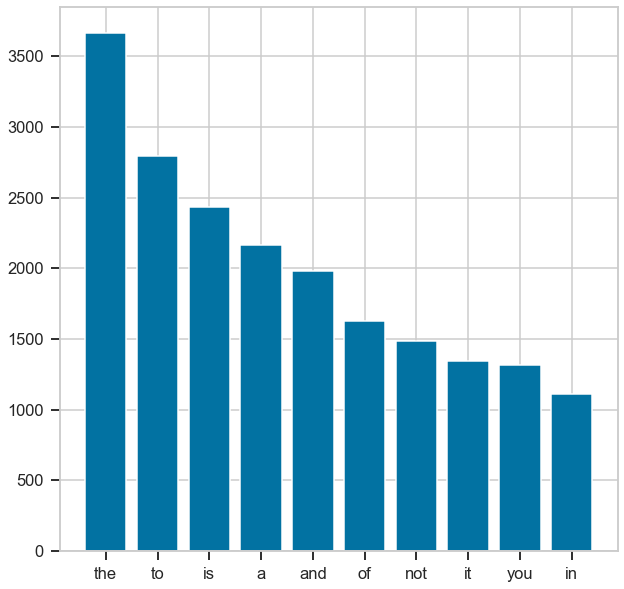

In [1191]:
# Before removing the stopwords let's take a look at them 
%matplotlib inline
from matplotlib import pyplot as plt

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    x,y=zip(*top)
    plt.figure(figsize=(10,10))
    plt.bar(x,y)
    
plot_top_stopwords_barchart(df['text_str'])

In [1188]:
# A for-loop with a lambda function will iterate over each token and give us new tokens without the stopwords

df['stopwords_removed'] = df['tokenised'].apply(lambda x: [word for word in x if word not in stopwords])
df.head()

,status_id,text,annontation,new_cat,length,no_contract,text_str,tokenised,stopwords_removed
0,0,"PAGS PARODY! Plus, Joe talks coronavirus and h...",irrelevant,2,133,"[PAGS, PARODY!, Plus,, Joe, talks, coronavirus...",pags parody plus joe talks coronavirus and has...,"[pags, parody, plus, joe, talks, coronavirus, ...","[pags, parody, plus, joe, talks, coronavirus, ..."
1,1,#coronavirus shows that racists have absolutel...,irrelevant,2,306,"[#coronavirus, shows, that, racists, have, abs...",coronavirus shows that racists have absolutely...,"[coronavirus, shows, that, racists, have, abso...","[coronavirus, shows, racists, absolutely, 2, m..."
2,2,@Laura1206 @ShitChester I would expect front l...,irrelevant,2,241,"[@Laura1206, @ShitChester, I, would, expect, f...",laura1206 shitchester i would expect front lin...,"[laura1206, shitchester, i, would, expect, fro...","[laura1206, shitchester, would, expect, front,..."
3,3,The coronavirus is not only affecting the way ...,irrelevant,2,127,"[The, coronavirus, is, not, only, affecting, t...",the coronavirus is not only affecting the way ...,"[the, coronavirus, is, not, only, affecting, t...","[coronavirus, affecting, way, live, also, dram..."
4,4,I hope your father recovers from the virus as ...,politics,2,304,"[I, hope, your, father, recovers, from, the, v...",i hope your father recovers from the virus as ...,"[i, hope, your, father, recovers, from, the, v...","[hope, father, recovers, virus, soonas, possib..."


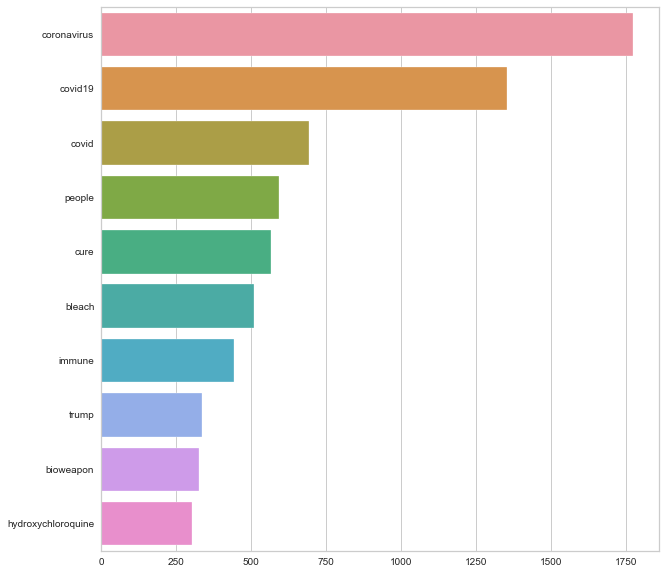

In [1081]:
# This is lookign at the most frequent words that are not stop words 

import seaborn as sns
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:50]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)
    
plot_top_non_stopwords_barchart(df['text_str'])

Being a covid dataset it makes sense for the most common word to be Coronavirus. The other main themes invlove a cure, whether legitimate or not such as bleach or hydrochloroquine. We can tell this dataset was at a time where there were still a lot of conspiracies going around and when Trump was USA president. The belach could be associated with misinformation provided by the Trump of comsuming bleach to treat covid or just general as a prevention for spread of covid, witht the latter less likely due to it's popularity. 

In [1082]:
#nltk.download('wordnet')
#nltk.download('omw-1.4')

In [1083]:
#nltk.download('averaged_perceptron_tagger')

#### <font color='purple'> Part of Speech Tagging</font>

Part of speach tagging is popular in NLP, it is the process of categorising words from a corpus into different lexical terms (such as adverbs, nouns, verbs) depending on the word meaning and the context behind it. 

In [1084]:
#Assign POS tags
df['pos_tags'] = df['stopwords_removed'].apply(nltk.tag.pos_tag)
df.head()


,status_id,text,annontation,new_cat,length,no_contract,text_str,tokenised,stopwords_removed,pos_tags
0,0,"PAGS PARODY! Plus, Joe talks coronavirus and h...",irrelevant,2,133,"[PAGS, PARODY!, Plus,, Joe, talks, coronavirus...",pags parody plus joe talks coronavirus and has...,"[pags, parody, plus, joe, talks, coronavirus, ...","[pags, parody, plus, joe, talks, coronavirus, ...","[(pags, NNS), (parody, NN), (plus, CC), (joe, ..."
1,1,#coronavirus shows that racists have absolutel...,irrelevant,2,306,"[#coronavirus, shows, that, racists, have, abs...",coronavirus shows that racists have absolutely...,"[coronavirus, shows, that, racists, have, abso...","[coronavirus, shows, that, racists, have, abso...","[(coronavirus, NN), (shows, VBZ), (that, IN), ..."
2,2,@Laura1206 @ShitChester I would expect front l...,irrelevant,2,241,"[@Laura1206, @ShitChester, I, would, expect, f...",laura1206 shitchester i would expect front lin...,"[laura1206, shitchester, i, would, expect, fro...","[laura1206, shitchester, i, would, expect, fro...","[(laura1206, JJ), (shitchester, NN), (i, NN), ..."
3,3,The coronavirus is not only affecting the way ...,irrelevant,2,127,"[The, coronavirus, is, not, only, affecting, t...",the coronavirus is not only affecting the way ...,"[the, coronavirus, is, not, only, affecting, t...","[the, coronavirus, is, not, only, affecting, t...","[(the, DT), (coronavirus, NN), (is, VBZ), (not..."
4,4,I hope your father recovers from the virus as ...,politics,2,304,"[I, hope, your, father, recovers, from, the, v...",i hope your father recovers from the virus as ...,"[i, hope, your, father, recovers, from, the, v...","[i, hope, your, father, recovers, from, the, v...","[(i, NNS), (hope, VBP), (your, PRP$), (father,..."


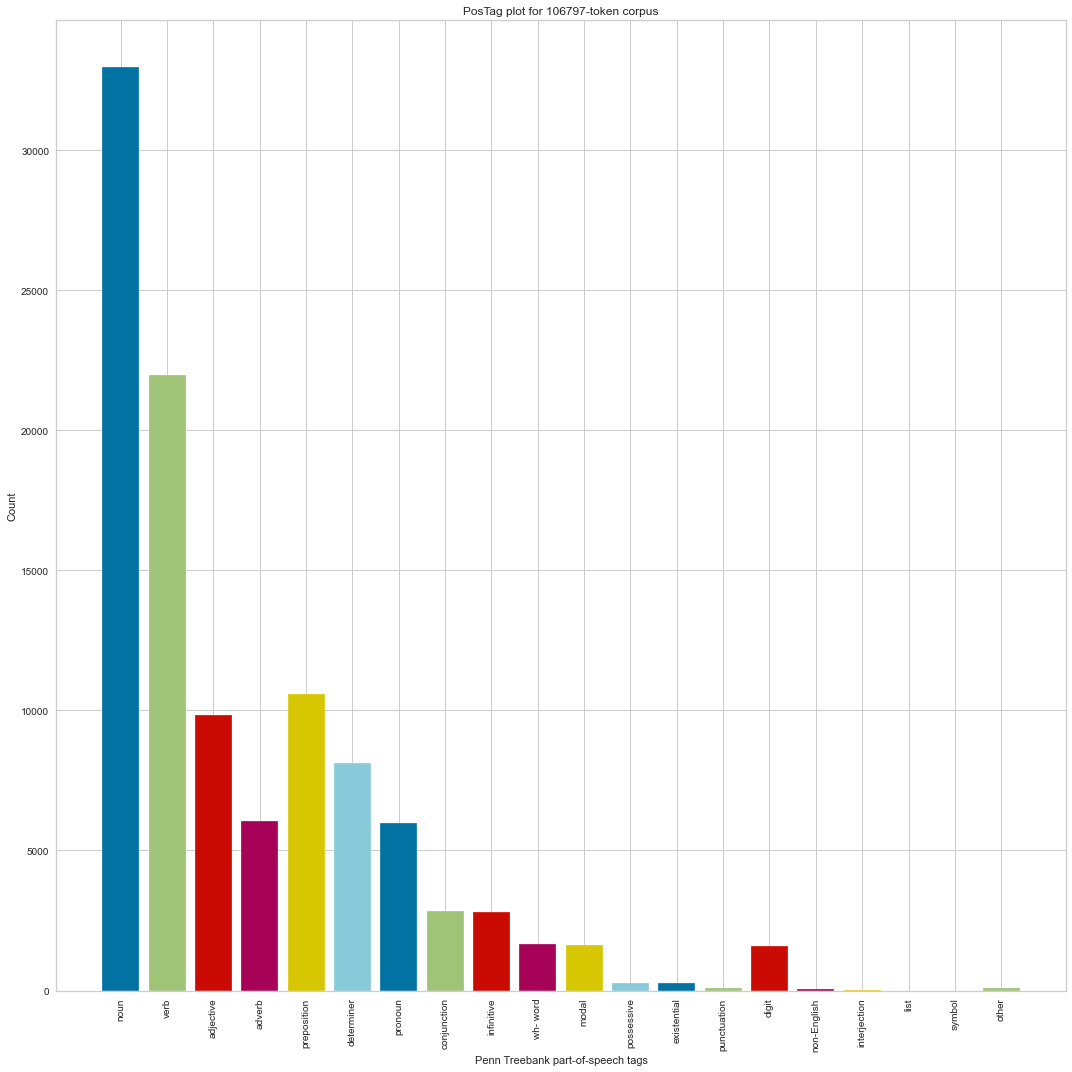

<AxesSubplot:title={'center':'PosTag plot for 106797-token corpus'}, xlabel='Penn Treebank part-of-speech tags', ylabel='Count'>

In [1085]:
# Let's look at the POS tags for our data set 
tagged_stanzas = []
tagged = []

for word in df['stopwords_removed']:
  tagged_word = nltk.pos_tag(word)
  tagged_stanzas.append(tagged_word)

# This format is necassary otherwise an error is given 
tagged.append(tagged_stanzas)


# Let's visualise the POS 

from yellowbrick.text import PosTagVisualizer
plt.figure(figsize=(15,15))
viz = PosTagVisualizer()
viz.fit(tagged)
viz.show()


This would be very interesting for someone with greater knowledge surrounding linguistics and understanding how communication is over social media in a pandemic. Due to time limits this could not be further explored. If correctly used this can help with the classification model too. 

#### <font color='purple'> N-grams </font>

We will create a bigram and trigram to look at two word sequences. This is done to convert the unstructed format text to a more structrues format. This is espeically useful in certain application in NLP such as spelling correction, word breaking and text summarization.

In [1086]:
# In order to look at N grams, we are going to join the tokens 

df['stopwords_rem_str'] = [' '.join(map(str, l)) for l in df['stopwords_removed']]
df

,status_id,text,annontation,new_cat,length,no_contract,text_str,tokenised,stopwords_removed,pos_tags,stopwords_rem_str
0,0,"PAGS PARODY! Plus, Joe talks coronavirus and h...",irrelevant,2,133,"[PAGS, PARODY!, Plus,, Joe, talks, coronavirus...",pags parody plus joe talks coronavirus and has...,"[pags, parody, plus, joe, talks, coronavirus, ...","[pags, parody, plus, joe, talks, coronavirus, ...","[(pags, NNS), (parody, NN), (plus, CC), (joe, ...",pags parody plus joe talks coronavirus and has...
1,1,#coronavirus shows that racists have absolutel...,irrelevant,2,306,"[#coronavirus, shows, that, racists, have, abs...",coronavirus shows that racists have absolutely...,"[coronavirus, shows, that, racists, have, abso...","[coronavirus, shows, that, racists, have, abso...","[(coronavirus, NN), (shows, VBZ), (that, IN), ...",coronavirus shows that racists have absolutely...
2,2,@Laura1206 @ShitChester I would expect front l...,irrelevant,2,241,"[@Laura1206, @ShitChester, I, would, expect, f...",laura1206 shitchester i would expect front lin...,"[laura1206, shitchester, i, would, expect, fro...","[laura1206, shitchester, i, would, expect, fro...","[(laura1206, JJ), (shitchester, NN), (i, NN), ...",laura1206 shitchester i would expect front lin...
3,3,The coronavirus is not only affecting the way ...,irrelevant,2,127,"[The, coronavirus, is, not, only, affecting, t...",the coronavirus is not only affecting the way ...,"[the, coronavirus, is, not, only, affecting, t...","[the, coronavirus, is, not, only, affecting, t...","[(the, DT), (coronavirus, NN), (is, VBZ), (not...",the coronavirus is not only affecting the way ...
4,4,I hope your father recovers from the virus as ...,politics,2,304,"[I, hope, your, father, recovers, from, the, v...",i hope your father recovers from the virus as ...,"[i, hope, your, father, recovers, from, the, v...","[i, hope, your, father, recovers, from, the, v...","[(i, NNS), (hope, VBP), (your, PRP$), (father,...",i hope your father recovers from the virus as ...
...,...,...,...,...,...,...,...,...,...,...,...
3637,3637,Da fark is wrong with these people?!\n\nhttps:...,calling out or correction,1,61,"[Da, fark, is, wrong, with, these, people?!, h...",da fark is wrong with these people httpstcodxm...,"[da, fark, is, wrong, with, these, people, htt...","[da, fark, is, wrong, with, these, people, htt...","[(da, NN), (fark, NN), (is, VBZ), (wrong, JJ),...",da fark is wrong with these people httpstcodxm...
3638,3638,Doctor Finds Cure to COVID-19 (without Vaccine...,fake cure,0,84,"[Doctor, Finds, Cure, to, COVID-19, (without, ...",doctor finds cure to covid19 without vaccine h...,"[doctor, finds, cure, to, covid19, without, va...","[doctor, finds, cure, to, covid19, without, va...","[(doctor, NN), (finds, VBZ), (cure, NN), (to, ...",doctor finds cure to covid19 without vaccine h...
3639,3639,I can’t believe people legitimately think that...,calling out or correction,1,178,"[I, cannot, believe, people, legitimately, thi...",i cannot believe people legitimately think tha...,"[i, can, not, believe, people, legitimately, t...","[i, can, not, believe, people, legitimately, t...","[(i, NN), (can, MD), (not, RB), (believe, VB),...",i can not believe people legitimately think th...
3640,3640,"...(wrong with Trump continues), \n-Will push ...",politics,2,270,"[...(wrong, with, Trump, continues),, -Will, p...",wrong with trump continues will push pressure ...,"[wrong, with, trump, continues, will, push, pr...","[wrong, with, trump, continues, will, push, pr...","[(wrong, JJ), (with, IN), (trump, NN), (contin...",wrong with trump continues will push pressure ...


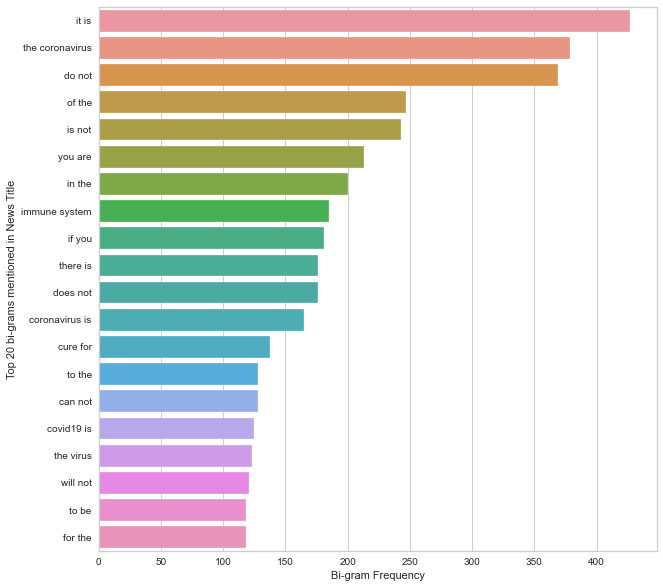

In [1087]:
# Let's visualise the bigram first

def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(text,n)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    plt.figure(figsize=(10,10))
    plt.xlabel("Bi-gram Frequency")
    plt.ylabel("Top 20 bi-grams mentioned in News Title")
    sns.barplot(x=y,y=x)

plot_top_ngrams_barchart(df['stopwords_rem_str'],2)

Even though an effort has been made to remove stop words, they still exist and is not very informative. The most interesting bigram would be the immune system. 

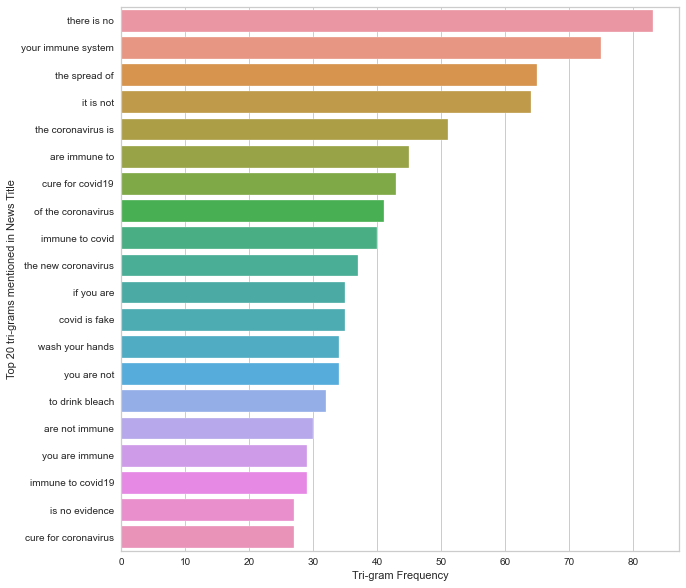

In [1088]:
#Tri-grams 

def plot_top_ngrams_barchart(text, n=3):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(text,n)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    plt.figure(figsize=(10,10))
    plt.xlabel("Tri-gram Frequency")
    plt.ylabel("Top 20 tri-grams mentioned in News Title")
    sns.barplot(x=y,y=x)


plot_top_ngrams_barchart(df['stopwords_rem_str'],3)

The Trigram is much more infomrative and we can see more useful sequences of words. There are a lot of notions of corrections, advice, and statements. The 'to drink bleach' agrees with the assumption that the dataset was collected around the time Trump suggested drinking/injecting bleach which resulted in deaths in the USA. We can generally spot great sentiments from this trigram such as disbelief and negative feelings towards covid. 

#### <font color='purple'> Lemmatisation </font>

We will lemmatise instead of stemming because it avoids reducing the word just to it's dictionary-specific morphological root of the word and considers the context of the word. It is more compuationally expensive however it is more likely to accurately achieve the base word - the lemma. 

In [1089]:
#Simply lemmatising the recently defined features 
df['text_string_lem'] = df['stopwords_rem_str'].apply(wordnet_lem.lemmatize)
df

,status_id,text,annontation,new_cat,length,no_contract,text_str,tokenised,stopwords_removed,pos_tags,stopwords_rem_str,text_string_lem
0,0,"PAGS PARODY! Plus, Joe talks coronavirus and h...",irrelevant,2,133,"[PAGS, PARODY!, Plus,, Joe, talks, coronavirus...",pags parody plus joe talks coronavirus and has...,"[pags, parody, plus, joe, talks, coronavirus, ...","[pags, parody, plus, joe, talks, coronavirus, ...","[(pags, NNS), (parody, NN), (plus, CC), (joe, ...",pags parody plus joe talks coronavirus and has...,pags parody plus joe talks coronavirus and has...
1,1,#coronavirus shows that racists have absolutel...,irrelevant,2,306,"[#coronavirus, shows, that, racists, have, abs...",coronavirus shows that racists have absolutely...,"[coronavirus, shows, that, racists, have, abso...","[coronavirus, shows, that, racists, have, abso...","[(coronavirus, NN), (shows, VBZ), (that, IN), ...",coronavirus shows that racists have absolutely...,coronavirus shows that racists have absolutely...
2,2,@Laura1206 @ShitChester I would expect front l...,irrelevant,2,241,"[@Laura1206, @ShitChester, I, would, expect, f...",laura1206 shitchester i would expect front lin...,"[laura1206, shitchester, i, would, expect, fro...","[laura1206, shitchester, i, would, expect, fro...","[(laura1206, JJ), (shitchester, NN), (i, NN), ...",laura1206 shitchester i would expect front lin...,laura1206 shitchester i would expect front lin...
3,3,The coronavirus is not only affecting the way ...,irrelevant,2,127,"[The, coronavirus, is, not, only, affecting, t...",the coronavirus is not only affecting the way ...,"[the, coronavirus, is, not, only, affecting, t...","[the, coronavirus, is, not, only, affecting, t...","[(the, DT), (coronavirus, NN), (is, VBZ), (not...",the coronavirus is not only affecting the way ...,the coronavirus is not only affecting the way ...
4,4,I hope your father recovers from the virus as ...,politics,2,304,"[I, hope, your, father, recovers, from, the, v...",i hope your father recovers from the virus as ...,"[i, hope, your, father, recovers, from, the, v...","[i, hope, your, father, recovers, from, the, v...","[(i, NNS), (hope, VBP), (your, PRP$), (father,...",i hope your father recovers from the virus as ...,i hope your father recovers from the virus as ...
...,...,...,...,...,...,...,...,...,...,...,...,...
3637,3637,Da fark is wrong with these people?!\n\nhttps:...,calling out or correction,1,61,"[Da, fark, is, wrong, with, these, people?!, h...",da fark is wrong with these people httpstcodxm...,"[da, fark, is, wrong, with, these, people, htt...","[da, fark, is, wrong, with, these, people, htt...","[(da, NN), (fark, NN), (is, VBZ), (wrong, JJ),...",da fark is wrong with these people httpstcodxm...,da fark is wrong with these people httpstcodxm...
3638,3638,Doctor Finds Cure to COVID-19 (without Vaccine...,fake cure,0,84,"[Doctor, Finds, Cure, to, COVID-19, (without, ...",doctor finds cure to covid19 without vaccine h...,"[doctor, finds, cure, to, covid19, without, va...","[doctor, finds, cure, to, covid19, without, va...","[(doctor, NN), (finds, VBZ), (cure, NN), (to, ...",doctor finds cure to covid19 without vaccine h...,doctor finds cure to covid19 without vaccine h...
3639,3639,I can’t believe people legitimately think that...,calling out or correction,1,178,"[I, cannot, believe, people, legitimately, thi...",i cannot believe people legitimately think tha...,"[i, can, not, believe, people, legitimately, t...","[i, can, not, believe, people, legitimately, t...","[(i, NN), (can, MD), (not, RB), (believe, VB),...",i can not believe people legitimately think th...,i can not believe people legitimately think th...
3640,3640,"...(wrong with Trump continues), \n-Will push ...",politics,2,270,"[...(wrong, with, Trump, continues),, -Will, p...",wrong with trump continues will push pressure ...,"[wrong, with, trump, continues, will, push, pr...","[wrong, with, trump, continues, will, push, pr...","[(wrong, JJ), (with, IN), (trump, NN), (contin...",w

##### <font color='purple'> Word Cloud </font>

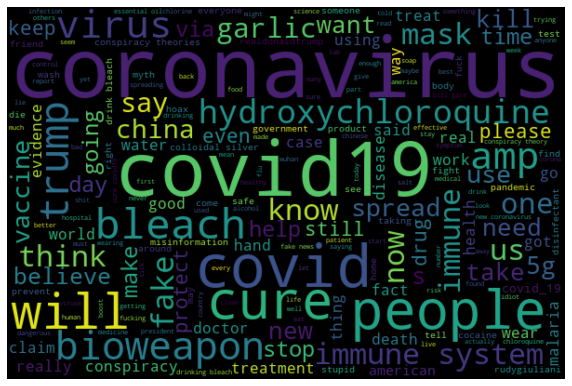

In [1090]:
#Creat a word cloud
all_words_lem = ' '.join([word for word in df['text_string_lem']])

%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(all_words_lem)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

Unsurprisingly, Covid terms are the most frequent terms. Other words include hydroxychloroquine which is not a direct treatment for covid but helps with the immune system, there were rumors this could potentially aid in recovering and most likely was used a lot on social media when discussing Covid as the death count/effects of Covid were quite high. There are conspiricies such as bio-weapon and mention of China, although not confirmed even now, these terms at the time could represent the desperation of people seeking answers. There are mentions of garlic which is false treatment as well as vaccines and Trump, all very popluar themes of time and would be interesting to analyse when examining our response to the pandemic. There is mention of will and this could relate to the theme of people being forced into certain precautions which they were not in favour of such as lockdowns and wearing masks. 

#### <font color='purple'> Named Entity Recognition </font>

NER comes under the field of Artificial Intelligence and is is one form of natural language processing (NLP). 
It looks at language developed naturally rather than language developed artifically such as the standardsised computer coding languages. Entities include names of people, organisations, locations, times, quantities, monetary values, percentages, and more.


In [1091]:
# Import required libraries
from tqdm import tqdm, tqdm_notebook

nlp = spacy.load('en_core_web_sm',
                 disable=['parser', 
                          'tagger',
                          'textcat'])

In [1095]:
#We will create a frame which would classify the words into the correct entities. 

frames = []
for i in tqdm_notebook(range(1000)):
    doc = df.loc[(i,'text_string_lem')]
    doc = nlp(doc)

    ents = [(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents if len(e.text.strip(' -—')) > 0]
    frame = pd.DataFrame(ents)
    
    frames.append(frame)

ner = pd.concat(frames)
ner.columns = ['Text','Start','Stop','NER_Type']
ner.tail()

/var/folders/zl/h52nhq_16f15jmzlb8z5lnv00000gn/T/ipykernel_19792/4218816020.py:4: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/1000 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning:

[W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.



,Text,Start,Stop,NER_Type
0,5,46,47,CARDINAL
0,ayurvedic formulation,0,21,ORG
1,charles,35,42,PERSON
2,shripad naik,66,78,PERSON
3,covid2019,113,122,PERSON


<AxesSubplot:xlabel='NER Types', ylabel='Counts'>

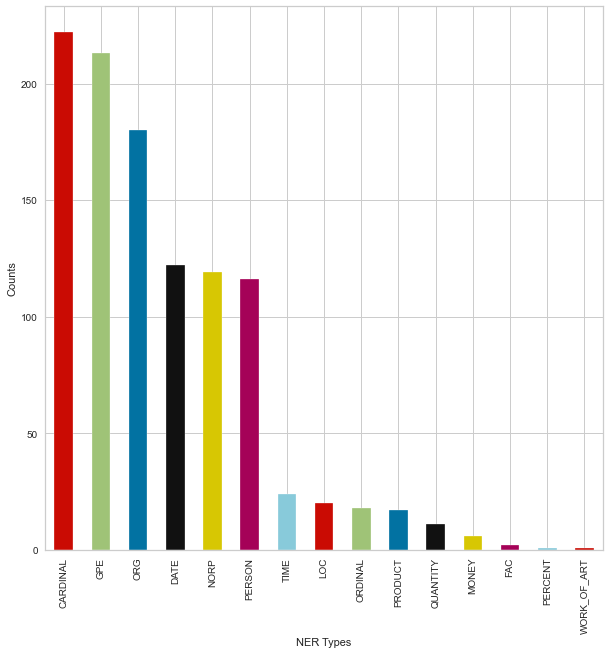

In [1096]:
#Create a visualisation of the NER

color_list = list('rgbkymc')  #red, green, blue, black, etc.
plt.figure(figsize=(10,10))
plt.xlabel("NER Types")
plt.ylabel("Counts")

ner.NER_Type.value_counts().plot(kind='bar', color = color_list)

We can see that that cardinal ('Numerals that do not fall under another type') is the highest entity found, this is probably due to tagging, twitter usernames and links. Then geopolitical entities came second, which is interesting and sparks the question of what types of geopolitical entities were mentioned as it is places that are politically defined. It would make sense for NORP (nationalities/religious/political groups to score high as there was a lot of information surrounding politics and conspriricies floating around the time. Things like money and work of art score low, this may be due to this not being a priority at the time. These categrories willbe further explored below. 

<AxesSubplot:xlabel='Top 20 people mentioned', ylabel='Counts'>

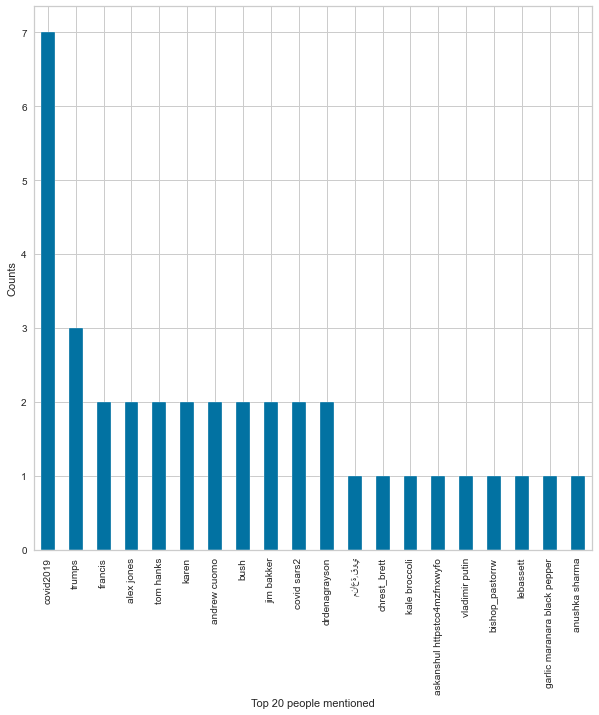

In [1097]:
#Let's look at persons first 

person = ner[ner.NER_Type == 'PERSON']
plt.figure(figsize=(10,10))
plt.xlabel("Top 20 people mentioned")
plt.ylabel("Counts")

person.Text.value_counts()[:20].plot(kind='bar')


Unfortunately it has assumed covid19 is a name. Unsurprisingly Trump is the most popular name, aside from that Alex jones, a far right conspiricy theorist formt USA is a very popular name and most likely contributed to conspiracy themes on twitter. Tom hanks was very popular in the news as he and his wife caught Covid quite early in the pandemic. Francis is most likely referring to the pope. Karen was a meme going around regarding entitled woman who displayed unfavourable behavior and was growing in popularity then. We can see Andrew Cuomo listed there too, and is most likely very popular due to him being the former governer of New York when the death count was the highest in the USA in his region. We can see other popular personalities such as Tim Bakker a televangelist. These people can be further researched when exploring the dataset for that time period, a lot of information/news can be retrieved simply from these persons. 


<AxesSubplot:xlabel='Top 20 Organizations mentioned', ylabel='Counts'>

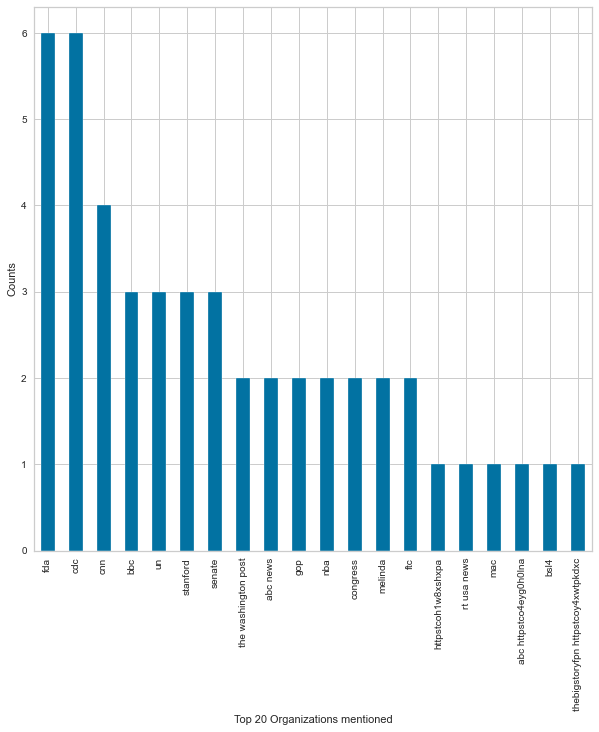

In [1098]:
#Let's look at organisations 

orgs = ner[ner.NER_Type == 'ORG']
plt.figure(figsize=(10,10))
plt.xlabel("Top 20 Organizations mentioned")
plt.ylabel("Counts")

orgs.Text.value_counts()[:20].plot(kind='bar')

FDA is the organisation used to administate food and drugs in the USA, and was probably popular when there were talks of false treatments going aorund. CDC which is the centre for control and prevention of disease is also very popular which makes sense as it's the pandemic and people are relying on treatment/advise coming from them. CNN and BBC are popular news outlets are are probably mentioned when discussing headline news. We can see a lot of news outlets as well as political themes discussed which are proabably due to the nature of the pandemic at the time. 

<AxesSubplot:xlabel='Top 20 Places mentioned', ylabel='Counts'>

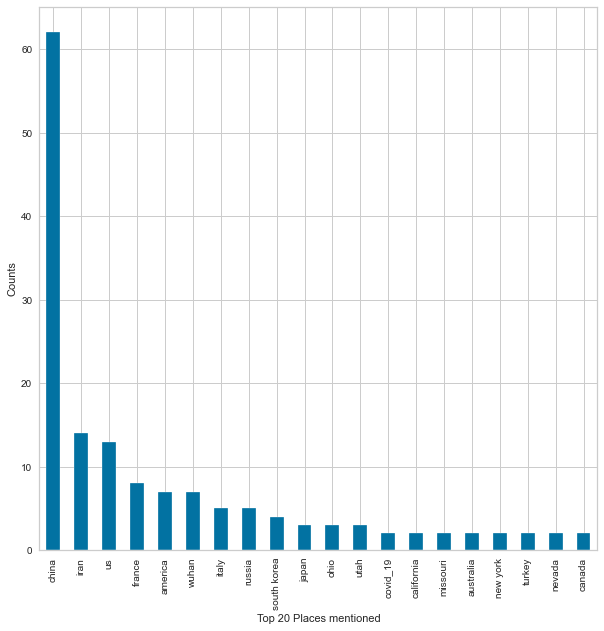

In [1099]:
#Let us look GeoPolitical entities. 

place = ner[ner.NER_Type == 'GPE']
plt.figure(figsize=(10,10))
plt.xlabel("Top 20 Places mentioned")
plt.ylabel("Counts")

place.Text.value_counts()[:20].plot(kind='bar')

China is extremely popular due to the confusion and people seeking answers of the origin of covid, not only this but to assess how the country is performing as they were the first country to go through a lockdown and high death rate, they could potentially be indicators of what is to come or what USA should be doing. Iran and Italy  had the most cases after China and were of great concern at the time. We can see Wuhan is very popluar too as it was the origin of covid-19. It would be interesting to know why France is so high. Overall NER is very interesting in unravelling what was happening at a certain time and to explore our raw response/behavior in a pandemic. 

## <font color='blue'> 2. Sentiment Analysis </font>

VADER  which stands Valence Aware Dictionary and Sentiment Reasoner is a lexicon analysis tool that is specifically used for sentiments expressed in social media. It is considered the gold standard when analsysing micro-blog texts such as tweets. Therefore is the most suitable for our analysis. Vader relies on a on a dictionary that maps lexical features to sentiment scores and is sensitive to both positive and negative polarity and and intensity of emotion. 

In [1100]:
#Let's download necassary libraries

nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zainabkhan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [1101]:
# Let's add polarity scores
df['polarity'] = df['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))
df.tail(3)


,status_id,text,annontation,new_cat,length,no_contract,text_str,tokenised,stopwords_removed,pos_tags,stopwords_rem_str,text_string_lem,polarity
3639,3639,I can’t believe people legitimately think that...,calling out or correction,1,178,"[I, cannot, believe, people, legitimately, thi...",i cannot believe people legitimately think tha...,"[i, can, not, believe, people, legitimately, t...","[i, can, not, believe, people, legitimately, t...","[(i, NN), (can, MD), (not, RB), (believe, VB),...",i can not believe people legitimately think th...,i can not believe people legitimately think th...,"{'neg': 0.0, 'neu': 0.907, 'pos': 0.093, 'comp..."
3640,3640,"...(wrong with Trump continues), \n-Will push ...",politics,2,270,"[...(wrong, with, Trump, continues),, -Will, p...",wrong with trump continues will push pressure ...,"[wrong, with, trump, continues, will, push, pr...","[wrong, with, trump, continues, will, push, pr...","[(wrong, JJ), (with, IN), (trump, NN), (contin...",wrong with trump continues will push pressure ...,wrong with trump continues will push pressure ...,"{'neg': 0.211, 'neu': 0.789, 'pos': 0.0, 'comp..."
3641,3641,For anyone who still believes that COVID-19 is...,calling out or correction,1,175,"[For, anyone, who, still, believes, that, COVI...",for anyone who still believes that covid19 is ...,"[for, anyone, who, still, believes, that, covi...","[for, anyone, who, still, believes, that, covi...","[(for, IN), (anyone, NN), (who, WP), (still, R...",for anyone who still believes that covid19 is ...,for anyone who still believes that covid19 is ...,"{'neg': 0.106, 'neu': 0.717, 'pos': 0.177, 'co..."


In [1102]:
# Change  the data structure so we can see the score for each category 
df = pd.concat(
    [df.drop([ 'polarity'], axis=1), 
     df['polarity'].apply(pd.Series)], axis=1)
df.head(3)

,status_id,text,annontation,new_cat,length,no_contract,text_str,tokenised,stopwords_removed,pos_tags,stopwords_rem_str,text_string_lem,neg,neu,pos,compound
0,0,"PAGS PARODY! Plus, Joe talks coronavirus and h...",irrelevant,2,133,"[PAGS, PARODY!, Plus,, Joe, talks, coronavirus...",pags parody plus joe talks coronavirus and has...,"[pags, parody, plus, joe, talks, coronavirus, ...","[pags, parody, plus, joe, talks, coronavirus, ...","[(pags, NNS), (parody, NN), (plus, CC), (joe, ...",pags parody plus joe talks coronavirus and has...,pags parody plus joe talks coronavirus and has...,0.000,0.863,0.137,0.4019
1,1,#coronavirus shows that racists have absolutel...,irrelevant,2,306,"[#coronavirus, shows, that, racists, have, abs...",coronavirus shows that racists have absolutely...,"[coronavirus, shows, that, racists, have, abso...","[coronavirus, shows, that, racists, have, abso...","[(coronavirus, NN), (shows, VBZ), (that, IN), ...",coronavirus shows that racists have absolutely...,coronavirus shows that racists have absolutely...,0.228,0.717,0.056,-0.8625
2,2,@Laura1206 @ShitChester I would expect front l...,irrelevant,2,241,"[@Laura1206, @ShitChester, I, would, expect, f...",laura1206 shitchester i would expect front lin...,"[laura1206, shitchester, i, would, expect, fro...","[laura1206, shitchester, i, would, expect, fro...","[(laura1206, JJ), (shitchester, NN), (i, NN), ...",laura1206 shitchester i would expect front lin...,laura1206 shitchester i would expect front lin...,0.055,0.945,0.000,-0.3353


In [1103]:
#Define how the sentiments will be established 
df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
df.head(4)

,status_id,text,annontation,new_cat,length,no_contract,text_str,tokenised,stopwords_removed,pos_tags,stopwords_rem_str,text_string_lem,neg,neu,pos,compound,sentiment
0,0,"PAGS PARODY! Plus, Joe talks coronavirus and h...",irrelevant,2,133,"[PAGS, PARODY!, Plus,, Joe, talks, coronavirus...",pags parody plus joe talks coronavirus and has...,"[pags, parody, plus, joe, talks, coronavirus, ...","[pags, parody, plus, joe, talks, coronavirus, ...","[(pags, NNS), (parody, NN), (plus, CC), (joe, ...",pags parody plus joe talks coronavirus and has...,pags parody plus joe talks coronavirus and has...,0.000,0.863,0.137,0.4019,positive
1,1,#coronavirus shows that racists have absolutel...,irrelevant,2,306,"[#coronavirus, shows, that, racists, have, abs...",coronavirus shows that racists have absolutely...,"[coronavirus, shows, that, racists, have, abso...","[coronavirus, shows, that, racists, have, abso...","[(coronavirus, NN), (shows, VBZ), (that, IN), ...",coronavirus shows that racists have absolutely...,coronavirus shows that racists have absolutely...,0.228,0.717,0.056,-0.8625,negative
2,2,@Laura1206 @ShitChester I would expect front l...,irrelevant,2,241,"[@Laura1206, @ShitChester, I, would, expect, f...",laura1206 shitchester i would expect front lin...,"[laura1206, shitchester, i, would, expect, fro...","[laura1206, shitchester, i, would, expect, fro...","[(laura1206, JJ), (shitchester, NN), (i, NN), ...",laura1206 shitchester i would expect front lin...,laura1206 shitchester i would expect front lin...,0.055,0.945,0.000,-0.3353,negative
3,3,The coronavirus is not only affecting the way ...,irrelevant,2,127,"[The, coronavirus, is, not, only, affecting, t...",the coronavirus is not only affecting the way ...,"[the, coronavirus, is, not, only, affecting, t...","[the, coronavirus, is, not, only, affecting, t...","[(the, DT), (coronavirus, NN), (is, VBZ), (not...",the coronavirus is not only affecting the way ...,the coronavirus is not only affecting the way ...,0.170,0.830,0.000,-0.5994,negative


In [1104]:
# Tweet with highest positive sentiment
df.loc[df['compound'].idxmax()].values

array([2663,
       "I don't put personal life situations on Twitter, but I've had three friends die from Covid-19. Speak their names: Danielle Cole, my friend from college, Guy Hunter, good friend from college, and my daughters best friends sister, age 40. Shove fake virus talk.",
       'calling out or correction', 1, 259,
       list(['I', 'do not', 'put', 'personal', 'life', 'situations', 'on', 'Twitter,', 'but', 'I have', 'had', 'three', 'friends', 'die', 'from', 'Covid-19.', 'Speak', 'their', 'names:', 'Danielle', 'Cole,', 'my', 'friend', 'from', 'college,', 'Guy', 'Hunter,', 'good', 'friend', 'from', 'college,', 'and', 'my', 'daughters', 'best', 'friends', 'sister,', 'age', '40.', 'Shove', 'fake', 'virus', 'talk.']),
       'i do not put personal life situations on twitter but i have had three friends die from covid19 speak their names danielle cole my friend from college guy hunter good friend from college and my daughters best friends sister age 40 shove fake virus talk',
    

Although negative tones of loved ones dying are present in this tweet, this has been classified as the most positive tweet, probably due to the underlying message of remembering loved ones and not forgetting them. There is no mention of hate  or resetment/negativity but just expression of love for those who have passed. 

In [1105]:
# Tweet with highest negative sentiment
df.loc[df['compound'].idxmin()].values

array([3335,
       'Everybody say “that COVID shit fake bro wtf that shit just conspiracy” and now I’m here at home sick as fuck because family don’t wanna listen y’all be tryna get rid of the wrong people 🚮🚮🚮 fuckin listen bro this shit no joke y’all don’t even understand how bad this shut hurt https://t.co/xb7izZ0bq6',
       'calling out or correction', 1, 300,
       list(['Everybody', 'say', '“that', 'COVID', 'shit', 'fake', 'bro', 'wtf', 'that', 'shit', 'just', 'conspiracy”', 'and', 'now', 'I am', 'here', 'at', 'home', 'sick', 'as', 'fuck', 'because', 'family', 'do not', 'want to', 'listen', 'you all', 'be', 'tryna', 'get', 'rid', 'of', 'the', 'wrong', 'people', '🚮🚮🚮', 'fuckin', 'listen', 'bro', 'this', 'shit', 'no', 'joke', 'you all', 'do not', 'even', 'understand', 'how', 'bad', 'this', 'shut', 'hurt', 'https://t.co/xb7izZ0bq6']),
       'everybody say that covid shit fake bro wtf that shit just conspiracy and now i am here at home sick as fuck because family do not want to li

There is a lot of foul langauge and expression of frustration at family and general society and even pain which is why this is decribed as the most negative tweet. 

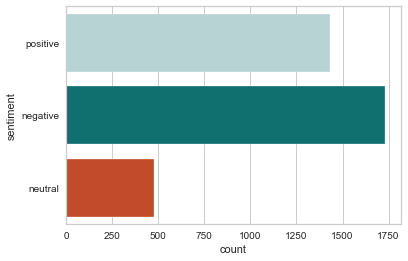

In [1106]:
# Number of tweets 
sns.countplot(y='sentiment', 
             data=df, 
             palette=['#b2d8d8',"#008080", '#db3d13']
             );

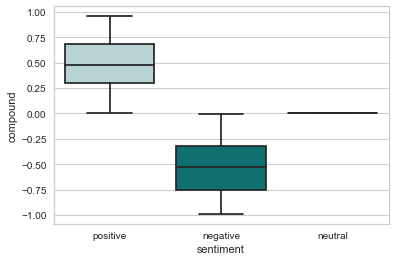

In [1107]:
# Boxplot
sns.boxplot(y='compound', 
            x='sentiment',
            palette=['#b2d8d8',"#008080", '#db3d13'], 
            data=df);

The interquartile range for the negetive tweets is sligtly larger than positive tweets. Generally there are more negative tweets which simply could be a sign of frustration, the upset caused by high rates of death or poorer quality of life due to restrictions. People are more likely to resort to Twitter to express their negative emotion as that is it's purpose, a platform to express you opinion and share information with others. 


In [1108]:
#Let's look at positive sentiment tweets

df_pos=df.loc[df['sentiment'] == 'positive']
df_pos


,status_id,text,annontation,new_cat,length,no_contract,text_str,tokenised,stopwords_removed,pos_tags,stopwords_rem_str,text_string_lem,neg,neu,pos,compound,sentiment
0,0,"PAGS PARODY! Plus, Joe talks coronavirus and h...",irrelevant,2,133,"[PAGS, PARODY!, Plus,, Joe, talks, coronavirus...",pags parody plus joe talks coronavirus and has...,"[pags, parody, plus, joe, talks, coronavirus, ...","[pags, parody, plus, joe, talks, coronavirus, ...","[(pags, NNS), (parody, NN), (plus, CC), (joe, ...",pags parody plus joe talks coronavirus and has...,pags parody plus joe talks coronavirus and has...,0.000,0.863,0.137,0.4019,positive
5,5,Delhi HC restrains publication of certain adve...,true public health response,1,126,"[Delhi, HC, restrains, publication, of, certai...",delhi hc restrains publication of certain adve...,"[delhi, hc, restrains, publication, of, certai...","[delhi, hc, restrains, publication, of, certai...","[(delhi, NN), (hc, NN), (restrains, VBZ), (pub...",delhi hc restrains publication of certain adve...,delhi hc restrains publication of certain adve...,0.000,0.861,0.139,0.2732,positive
10,10,I protected myself from the coronavirus by wea...,sarcasm or satire,0,60,"[I, protected, myself, from, the, coronavirus,...",i protected myself from the coronavirus by wea...,"[i, protected, myself, from, the, coronavirus,...","[i, protected, myself, from, the, coronavirus,...","[(i, NN), (protected, VBD), (myself, PRP), (fr...",i protected myself from the coronavirus by wea...,i protected myself from the coronavirus by wea...,0.000,0.707,0.293,0.4404,positive
12,12,Health experts refute false claims that drinki...,calling out or correction,1,141,"[Health, experts, refute, false, claims, that,...",health experts refute false claims that drinki...,"[health, experts, refute, false, claims, that,...","[health, experts, refute, false, claims, that,...","[(health, NN), (experts, NNS), (refute, VBP), ...",health experts refute false claims that drinki...,health experts refute false claims that drinki...,0.000,0.859,0.141,0.3182,positive
13,13,"Like this tweet, which shares an article that ...",calling out or correction,1,250,"[Like, this, tweet,, which, shares, an, articl...",like this tweet which shares an article that f...,"[like, this, tweet, which, shares, an, article...","[like, this, tweet, which, shares, an, article...","[(like, IN), (this, DT), (tweet, NN), (which, ...",like this tweet which shares an article that f...,like this tweet which shares an article that f...,0.000,0.868,0.132,0.5719,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3627,3627,I could cure Covid 19 and still only get 2 lik...,irrelevant,2,62,"[I, could, cure, Covid, 19, and, still, only, ...",i could cure covid 19 and still only get 2 lik...,"[i, could, cure, covid, 19, and, still, only, ...","[i, could, cure, covid, 19, and, still, only, ...","[(i, NN), (could, MD), (cure, VB), (covid, JJ)...",i could cure covid 19 and still only get 2 lik...,i could cure covid 19 and still only get 2 lik...,0.000,0.797,0.203,0.4215,positive
3635,3635,Bill Gates never wears a mask and takes big be...,conspiracy,0,100,"[Bill, Gates, never, wears, a, mask, and, take...",bill gates never wears a mask and takes big be...,"[bill, gates, never, wears, a, mask, and, take...","[bill, gates, never, wears, a, mask, and, take...","[(bill, NN), (gates, VBZ), (never, RB), (wears...",bill gates never wears a mask and takes big be...,bill gates never wears a mask and takes big be...,0.000,0.822,0.178,0.3818,positive
3636,3636,"#TakeYourSAT Parents of America, please don't ...",politics,2,207,"[#TakeYourSAT, Parents, of, America,, please, ...",takeyoursat parents of america please do not t...,"[takeyoursat, parents, of, america, please, do...","[takeyoursat, parents, of, america, please, do...","[(takeyoursat, JJ), (parents, NNS), (of, IN), ...",takeyoursat parents of america please do not t...,takeyoursat parents of america please do not t...,0.000,0.933,

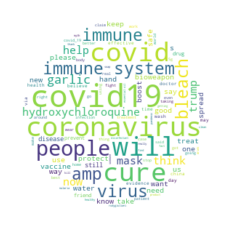

In [1109]:
#Let's create another word cloud

all_words_lem_pos = ' '.join([word for word in df_pos['text_string_lem']])
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(background_color="white", repeat=True, mask=mask)
wc.generate(all_words_lem_pos)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear");

In [1110]:
#Let's look at the most frequently used words where there is postive sentiment

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

words = nltk.word_tokenize(all_words_lem_pos)
fd = FreqDist(words)

fd.most_common(10)

[('the', 1446),
 ('to', 1243),
 ('is', 913),
 ('and', 865),
 ('a', 849),
 ('of', 691),
 ('coronavirus', 628),
 ('not', 617),
 ('covid19', 614),
 ('you', 590)]

Even though an effort has been made to remove stop words, they seem to be the most frequent. 

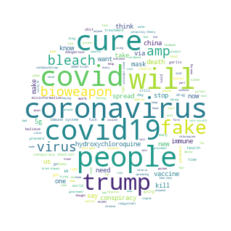

In [1111]:
#Now Let's look at the negative sentiment tweets 

df_neg=df.loc[df['sentiment'] == 'negative']
df_neg
all_words_lem_neg = ' '.join([word for word in df_neg['text_string_lem']])
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(background_color="white", repeat=True, mask=mask)
wc.generate(all_words_lem_neg)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear");

In [1112]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

words = nltk.word_tokenize(all_words_lem_neg)
fd = FreqDist(words)

fd.most_common(10)

[('the', 1918),
 ('to', 1378),
 ('is', 1339),
 ('a', 1142),
 ('and', 966),
 ('not', 863),
 ('coronavirus', 862),
 ('of', 795),
 ('it', 717),
 ('you', 667)]

Similarly the stop words are quite frequent. 

In [1114]:
df

,status_id,text,annontation,new_cat,length,no_contract,text_str,tokenised,stopwords_removed,pos_tags,stopwords_rem_str,text_string_lem,neg,neu,pos,compound,sentiment
0,0,"PAGS PARODY! Plus, Joe talks coronavirus and h...",irrelevant,2,133,"[PAGS, PARODY!, Plus,, Joe, talks, coronavirus...",pags parody plus joe talks coronavirus and has...,"[pags, parody, plus, joe, talks, coronavirus, ...","[pags, parody, plus, joe, talks, coronavirus, ...","[(pags, NNS), (parody, NN), (plus, CC), (joe, ...",pags parody plus joe talks coronavirus and has...,pags parody plus joe talks coronavirus and has...,0.000,0.863,0.137,0.4019,positive
1,1,#coronavirus shows that racists have absolutel...,irrelevant,2,306,"[#coronavirus, shows, that, racists, have, abs...",coronavirus shows that racists have absolutely...,"[coronavirus, shows, that, racists, have, abso...","[coronavirus, shows, that, racists, have, abso...","[(coronavirus, NN), (shows, VBZ), (that, IN), ...",coronavirus shows that racists have absolutely...,coronavirus shows that racists have absolutely...,0.228,0.717,0.056,-0.8625,negative
2,2,@Laura1206 @ShitChester I would expect front l...,irrelevant,2,241,"[@Laura1206, @ShitChester, I, would, expect, f...",laura1206 shitchester i would expect front lin...,"[laura1206, shitchester, i, would, expect, fro...","[laura1206, shitchester, i, would, expect, fro...","[(laura1206, JJ), (shitchester, NN), (i, NN), ...",laura1206 shitchester i would expect front lin...,laura1206 shitchester i would expect front lin...,0.055,0.945,0.000,-0.3353,negative
3,3,The coronavirus is not only affecting the way ...,irrelevant,2,127,"[The, coronavirus, is, not, only, affecting, t...",the coronavirus is not only affecting the way ...,"[the, coronavirus, is, not, only, affecting, t...","[the, coronavirus, is, not, only, affecting, t...","[(the, DT), (coronavirus, NN), (is, VBZ), (not...",the coronavirus is not only affecting the way ...,the coronavirus is not only affecting the way ...,0.170,0.830,0.000,-0.5994,negative
4,4,I hope your father recovers from the virus as ...,politics,2,304,"[I, hope, your, father, recovers, from, the, v...",i hope your father recovers from the virus as ...,"[i, hope, your, father, recovers, from, the, v...","[i, hope, your, father, recovers, from, the, v...","[(i, NNS), (hope, VBP), (your, PRP$), (father,...",i hope your father recovers from the virus as ...,i hope your father recovers from the virus as ...,0.199,0.695,0.107,-0.6977,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3637,3637,Da fark is wrong with these people?!\n\nhttps:...,calling out or correction,1,61,"[Da, fark, is, wrong, with, these, people?!, h...",da fark is wrong with these people httpstcodxm...,"[da, fark, is, wrong, with, these, people, htt...","[da, fark, is, wrong, with, these, people, htt...","[(da, NN), (fark, NN), (is, VBZ), (wrong, JJ),...",da fark is wrong with these people httpstcodxm...,da fark is wrong with these people httpstcodxm...,0.307,0.693,0.000,-0.4767,negative
3638,3638,Doctor Finds Cure to COVID-19 (without Vaccine...,fake cure,0,84,"[Doctor, Finds, Cure, to, COVID-19, (without, ...",doctor finds cure to covid19 without vaccine h...,"[doctor, finds, cure, to, covid19, without, va...","[doctor, finds, cure, to, covid19, without, va...","[(doctor, NN), (finds, VBZ), (cure, NN), (to, ...",doctor finds cure to covid19 without vaccine h...,doctor finds cure to covid19 without vaccine h...,0.000,1.000,0.000,0.0000,neutral
3639,3639,I can’t believe people legitimately think that...,calling out or correction,1,178,"[I, cannot, believe, people, legitimately, thi...",i cannot believe people legitimately think tha...,"[i, can, not, believe, people, legitimately, t...","[i, can, not, believe, people, legitimately, t...","[(i, NN), (can, MD), (not, RB), (believe, VB),...",i can not believe people legitimately think th...,i can not believe people legitimately think th...,0.000,0.907,0.093,0.4168,positive
3640,3640

## <font color='Blue'> 3. Text Classification </font>

In [1115]:
#Copy the dataframe 
df_copy=df.copy()
df_copy

,status_id,text,annontation,new_cat,length,no_contract,text_str,tokenised,stopwords_removed,pos_tags,stopwords_rem_str,text_string_lem,neg,neu,pos,compound,sentiment
0,0,"PAGS PARODY! Plus, Joe talks coronavirus and h...",irrelevant,2,133,"[PAGS, PARODY!, Plus,, Joe, talks, coronavirus...",pags parody plus joe talks coronavirus and has...,"[pags, parody, plus, joe, talks, coronavirus, ...","[pags, parody, plus, joe, talks, coronavirus, ...","[(pags, NNS), (parody, NN), (plus, CC), (joe, ...",pags parody plus joe talks coronavirus and has...,pags parody plus joe talks coronavirus and has...,0.000,0.863,0.137,0.4019,positive
1,1,#coronavirus shows that racists have absolutel...,irrelevant,2,306,"[#coronavirus, shows, that, racists, have, abs...",coronavirus shows that racists have absolutely...,"[coronavirus, shows, that, racists, have, abso...","[coronavirus, shows, that, racists, have, abso...","[(coronavirus, NN), (shows, VBZ), (that, IN), ...",coronavirus shows that racists have absolutely...,coronavirus shows that racists have absolutely...,0.228,0.717,0.056,-0.8625,negative
2,2,@Laura1206 @ShitChester I would expect front l...,irrelevant,2,241,"[@Laura1206, @ShitChester, I, would, expect, f...",laura1206 shitchester i would expect front lin...,"[laura1206, shitchester, i, would, expect, fro...","[laura1206, shitchester, i, would, expect, fro...","[(laura1206, JJ), (shitchester, NN), (i, NN), ...",laura1206 shitchester i would expect front lin...,laura1206 shitchester i would expect front lin...,0.055,0.945,0.000,-0.3353,negative
3,3,The coronavirus is not only affecting the way ...,irrelevant,2,127,"[The, coronavirus, is, not, only, affecting, t...",the coronavirus is not only affecting the way ...,"[the, coronavirus, is, not, only, affecting, t...","[the, coronavirus, is, not, only, affecting, t...","[(the, DT), (coronavirus, NN), (is, VBZ), (not...",the coronavirus is not only affecting the way ...,the coronavirus is not only affecting the way ...,0.170,0.830,0.000,-0.5994,negative
4,4,I hope your father recovers from the virus as ...,politics,2,304,"[I, hope, your, father, recovers, from, the, v...",i hope your father recovers from the virus as ...,"[i, hope, your, father, recovers, from, the, v...","[i, hope, your, father, recovers, from, the, v...","[(i, NNS), (hope, VBP), (your, PRP$), (father,...",i hope your father recovers from the virus as ...,i hope your father recovers from the virus as ...,0.199,0.695,0.107,-0.6977,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3637,3637,Da fark is wrong with these people?!\n\nhttps:...,calling out or correction,1,61,"[Da, fark, is, wrong, with, these, people?!, h...",da fark is wrong with these people httpstcodxm...,"[da, fark, is, wrong, with, these, people, htt...","[da, fark, is, wrong, with, these, people, htt...","[(da, NN), (fark, NN), (is, VBZ), (wrong, JJ),...",da fark is wrong with these people httpstcodxm...,da fark is wrong with these people httpstcodxm...,0.307,0.693,0.000,-0.4767,negative
3638,3638,Doctor Finds Cure to COVID-19 (without Vaccine...,fake cure,0,84,"[Doctor, Finds, Cure, to, COVID-19, (without, ...",doctor finds cure to covid19 without vaccine h...,"[doctor, finds, cure, to, covid19, without, va...","[doctor, finds, cure, to, covid19, without, va...","[(doctor, NN), (finds, VBZ), (cure, NN), (to, ...",doctor finds cure to covid19 without vaccine h...,doctor finds cure to covid19 without vaccine h...,0.000,1.000,0.000,0.0000,neutral
3639,3639,I can’t believe people legitimately think that...,calling out or correction,1,178,"[I, cannot, believe, people, legitimately, thi...",i cannot believe people legitimately think tha...,"[i, can, not, believe, people, legitimately, t...","[i, can, not, believe, people, legitimately, t...","[(i, NN), (can, MD), (not, RB), (believe, VB),...",i can not believe people legitimately think th...,i can not believe people legitimately think th...,0.000,0.907,0.093,0.4168,positive
3640,3640

We will be using tfidf and count vectoriser here, which stands for term-frequency (times)  inverse document-frequency. 
It looks at the frequency of tokens relative to the entire corpus. The more important or relevant a token is the higher the TF-IDF score and vice versa. 

In [1121]:
# Split into test and train data 
X = df_copy.loc[:,'text_string_lem']
y = df_copy.loc[:,'new_cat']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=55)

xtrain_tfidf = tfidf_vec.fit_transform(X_train)
xtest_tfidf = tfidf_vec.transform(X_test)

xtrain_tfidf

<2912x60731 sparse matrix of type '<class 'numpy.float64'>'
	with 152380 stored elements in Compressed Sparse Row format>

In [1131]:
#Define some functions to calculate scores we're interested in

def run_model(model_name):
    if model_name == 'Logistic Regression':
        model = LogisticRegression()
    elif model_name == 'Random Forest':
        model = RandomForestClassifier(n_estimators=100)
    elif model_name == 'Multinomial Naive Bayes':
        model = MultinomialNB()
    elif model_name == 'Linear SVC':
        model = LinearSVC() 

    oneVsRest = OneVsRestClassifier(model)
    oneVsRest.fit(xtrain_tfidf, y_train)
    y_pred = oneVsRest.predict(xtest_tfidf)
    
    
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    precision, recall, f1score, support = score(y_test, y_pred, average='micro')
    cm = confusion_matrix(y_test, y_pred)
    sns.set_context('talk')
    plt.figure(figsize=(30,30))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(model_name)
    plt.show()

    perform_list.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 2)),
        ('Precision', round(precision, 2)),
        ('Recall', round(recall, 2)),
        ('F1', round(f1score, 2)),
         ]))

<Figure size 2160x2160 with 0 Axes>

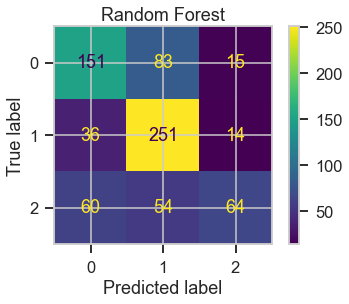

<Figure size 2160x2160 with 0 Axes>

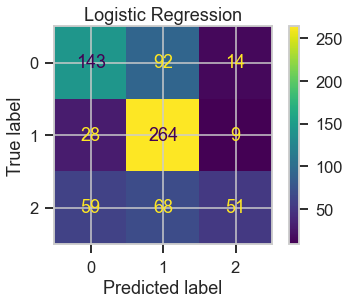

<Figure size 2160x2160 with 0 Axes>

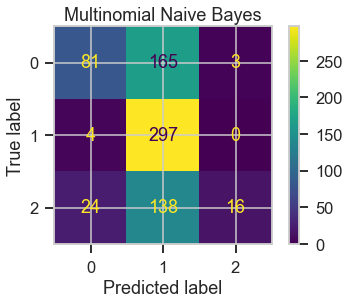

<Figure size 2160x2160 with 0 Axes>

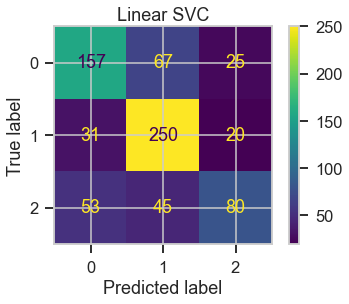

,Model,Test Accuracy,Precision,Recall,F1
0,Random Forest,64.01,0.64,0.64,0.64
1,Logistic Regression,62.91,0.63,0.63,0.63
2,Multinomial Naive Bayes,54.12,0.54,0.54,0.54
3,Linear SVC,66.90,0.67,0.67,0.67


In [1132]:
#Run the models

perform_list = []

run_model('Random Forest')
run_model('Logistic Regression')
run_model('Multinomial Naive Bayes')
run_model('Linear SVC')

model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[
    ['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]

model_performance

We can see that the Linear Support Vector Machine has performed the best in indentifying whether the tweet is misinformation or not, with random forest quite closely following. 

### <font color='Purple'> Text Classification model improvements </font>

Bert embeddings will be used to fine tune our classification model to get better predictions. It is important to note that it is extremely computationally expensive but such advanced word embeddings canhelp to improve scores. Due to it's contextual embeddings, it's performance is very high quality. 

In [1209]:
!pip install tensorflow_hub
import tensorflow as tf
import tensorflow_hub as hub
!pip install tensorflow-text
import tensorflow_text as text

     |████████████████████████████████| 108 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 3.4 MB/s eta 0:00:01


In [1210]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

2022-08-22 19:27:47.391886: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1211]:
# Split into test and train data 
X1 = df_copy.loc[:,'text_string_lem']
y1 = df_copy.loc[:,'new_cat']

X_train, X_test, y_train, y_test = train_test_split(
    X1, y1, test_size=0.2, random_state=55)

In [1212]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [1213]:
#Fit the model with the new Bert embeddings
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2, batch_size = 32)

Epoch 1/2
91/91 [==============================] - 2312s 25s/step - loss: 0.4005 - accuracy: 0.4186
Epoch 2/2
91/91 [==============================] - 2130s 23s/step - loss: 0.3639 - accuracy: 0.4200


In [1215]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
print(y_predicted)

KeyboardInterrupt: 

The Bert embeddings took too long. With extra time we could've seen the effects of such a powerful tool. 

We can take further steps such as below to further improve the classification model, not only this but we can use grid search for model tuning. Again with the intent of improving the classification model scores

In [ ]:
#Remove words that are less than two letters 
df_copy['text_string_final'] = df_copy['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))

#remove infrequent words in our case this will be words that appear more than 4 times
df_copy['text_string_fdist_final'] = df_copy['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 4 ]))

#Remove rows with irrelevant data
df_relevant = df_copy[df.new_cat != 2]
